In [ ]:
import os

In [ ]:
os.getcwd()

# Script to plot average causal effects

This script loads sets of hundreds of causal traces that have been computed by the
`experiment.causal_trace` program, and then aggregates the results to compute
Average Indirect Effects and Average Total Effects as well as some other information.


In [9]:
import numpy, os
from matplotlib import pyplot as plt

plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["mathtext.fontset"] = "dejavuserif"

# Uncomment the architecture to plot.

# arch = "gpt2-xl"
# archname = "GPT-2-XL"

# arch = 'EleutherAI_gpt-j-6B'
# archname = 'GPT-J-6B'

# arch = 'EleutherAI_gpt-neox-20b'
# archname = 'GPT-NeoX-20B'

arch = "ns3_r0_microsoft_phi-1_5"
archname = "microsoft phi 1.5"

class Avg:
    def __init__(self):
        self.d = []

    def add(self, v):
        self.d.append(v[None])

    def add_all(self, vv):
        self.d.append(vv)

    def avg(self):
        return numpy.concatenate(self.d).mean(axis=0)

    def std(self):
        return numpy.concatenate(self.d).std(axis=0)

    def size(self):
        return sum(datum.shape[0] for datum in self.d)

In [11]:
def read_knowlege(count=150, kind=None, arch="gpt2-xl"):
    dirname = f"../results/{arch}/causal_trace/cases/"
    kindcode = "" if not kind else f"_{kind}"
    (
        avg_fe,
        avg_ee,
        avg_le,
        avg_fa,
        avg_ea,
        avg_la,
        avg_hs,
        avg_ls,
        avg_fs,
        avg_fle,
        avg_fla,
    ) = [Avg() for _ in range(11)]
    for i in range(count):
        try:
            data = numpy.load(f"{dirname}/knowledge_{i}{kindcode}.npz")        
        except:
            continue
        # Only consider cases where the model begins with the correct prediction
        if "correct_prediction" in data and not data["correct_prediction"]:
            continue
        scores = data["scores"]
        first_e, first_a = data["subject_range"]
        last_e = first_a - 1
        last_a = len(scores) - 1
        # original prediction
        avg_hs.add(data["high_score"])
        # prediction after subject is corrupted
        avg_ls.add(data["low_score"])
        avg_fs.add(scores.max())
        # some maximum computations
        avg_fle.add(scores[last_e].max())
        avg_fla.add(scores[last_a].max())
        # First subject middle, last subjet.
        avg_fe.add(scores[first_e])
        avg_ee.add_all(scores[first_e + 1 : last_e])
        avg_le.add(scores[last_e])
        # First after, middle after, last after
        avg_fa.add(scores[first_a])
        avg_ea.add_all(scores[first_a + 1 : last_a])
        avg_la.add(scores[last_a])

    result = numpy.stack(
        [
            avg_fe.avg(),
            avg_ee.avg(),
            avg_le.avg(),
            avg_fa.avg(),
            avg_ea.avg(),
            avg_la.avg(),
        ]
    )
    result_std = numpy.stack(
        [
            avg_fe.std(),
            avg_ee.std(),
            avg_le.std(),
            avg_fa.std(),
            avg_ea.std(),
            avg_la.std(),
        ]
    )
    print("Average Total Effect", avg_hs.avg() - avg_ls.avg())
    print(
        "Best average indirect effect on last subject",
        avg_le.avg().max() - avg_ls.avg(),
    )
    print(
        "Best average indirect effect on last token", avg_la.avg().max() - avg_ls.avg()
    )
    print("Average best-fixed score", avg_fs.avg())
    print("Average best-fixed on last subject token score", avg_fle.avg())
    print("Average best-fixed on last word score", avg_fla.avg())
    print("Argmax at last subject token", numpy.argmax(avg_le.avg()))
    print("Max at last subject token", numpy.max(avg_le.avg()))
    print("Argmax at last prompt token", numpy.argmax(avg_la.avg()))
    print("Max at last prompt token", numpy.max(avg_la.avg()))
    return dict(
        low_score=avg_ls.avg(), result=result, result_std=result_std, size=avg_fe.size()
    )

In [3]:
def plot_array(
    differences,
    kind=None,
    savepdf=None,
    title=None,
    low_score=None,
    high_score=None,
    archname="GPT2-XL",
):
    if low_score is None:
        low_score = differences.min()
    if high_score is None:
        high_score = differences.max()
    answer = "AIE"
    labels = [
        "First subject token",
        "Middle subject tokens",
        "Last subject token",
        "First subsequent token",
        "Further tokens",
        "Last token",
    ]

    fig, ax = plt.subplots(figsize=(3.5, 2), dpi=200)
    h = ax.pcolor(
        differences,
        cmap={None: "Purples", "mlp": "Greens", "attn": "Reds"}[kind],
        vmin=low_score,
        vmax=high_score,
    )
    if title:
        ax.set_title(title)
    ax.invert_yaxis()
    ax.set_yticks([0.5 + i for i in range(len(differences))])
    ax.set_xticks([0.5 + i for i in range(0, differences.shape[1] - 6, 5)])
    ax.set_xticklabels(list(range(0, differences.shape[1] - 6, 5)))
    ax.set_yticklabels(labels)
    if kind is None:
        ax.set_xlabel(f"single patched layer within {archname}")
    else:
        ax.set_xlabel(f"center of interval of 10 patched {kind} layers")
    cb = plt.colorbar(h)
    # The following should be cb.ax.set_xlabel(answer), but this is broken in matplotlib 3.5.1.
    if answer:
        cb.ax.set_title(str(answer).strip(), y=-0.16, fontsize=10)

    if savepdf:
        os.makedirs(os.path.dirname(savepdf), exist_ok=True)
        plt.savefig(savepdf, bbox_inches="tight")
    plt.show()

Average Total Effect 0.42550782211353866
Best average indirect effect on last subject 0.15800627418091384
Best average indirect effect on last token 0.4255079115205058
Average best-fixed score 0.48769975
Average best-fixed on last subject token score 0.24290925
Average best-fixed on last word score 0.48217574
Argmax at last subject token 4
Max at last subject token 0.20896398
Argmax at last prompt token 23
Max at last prompt token 0.4764656


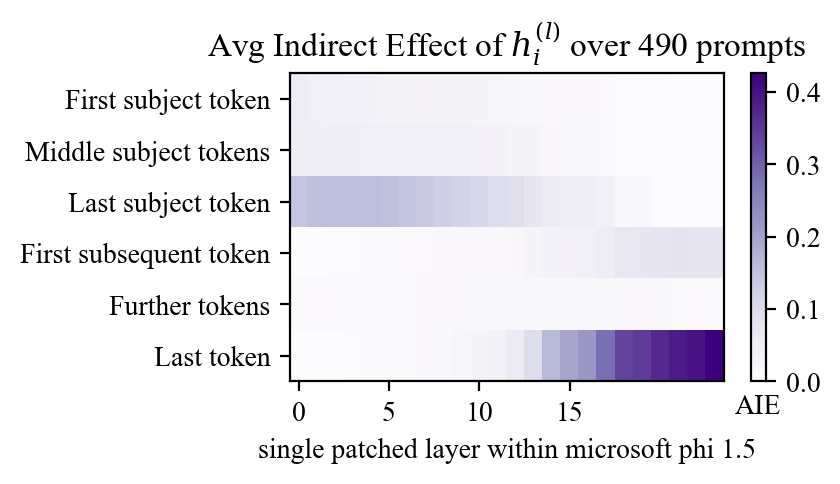

Average Total Effect 0.42550782211353866
Best average indirect effect on last subject 0.15240100868275253
Best average indirect effect on last token 0.04543633111050217
Average best-fixed score 0.29666826
Average best-fixed on last subject token score 0.22023599
Average best-fixed on last word score 0.109784015
Argmax at last subject token 5
Max at last subject token 0.20335871
Argmax at last prompt token 16
Max at last prompt token 0.09639403


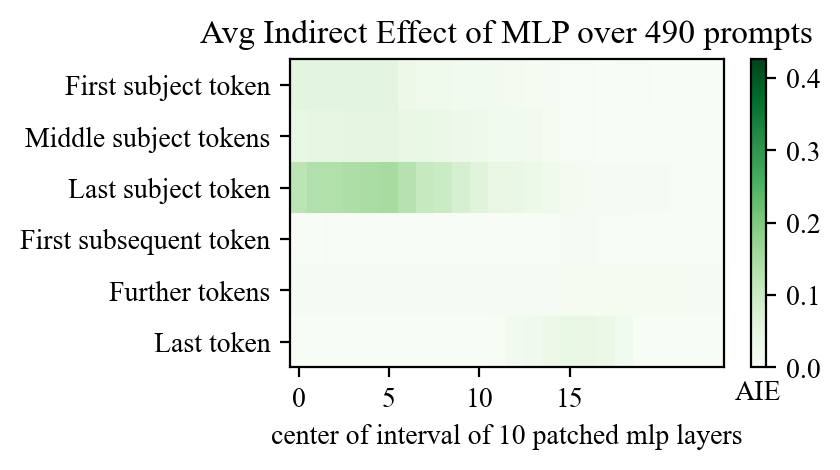

Average Total Effect 0.42550782211353866
Best average indirect effect on last subject 0.11860013850262253
Best average indirect effect on last token 0.28187320478489486
Average best-fixed score 0.37602273
Average best-fixed on last subject token score 0.18271089
Average best-fixed on last word score 0.36543018
Argmax at last subject token 5
Max at last subject token 0.16955784
Argmax at last prompt token 14
Max at last prompt token 0.3328309


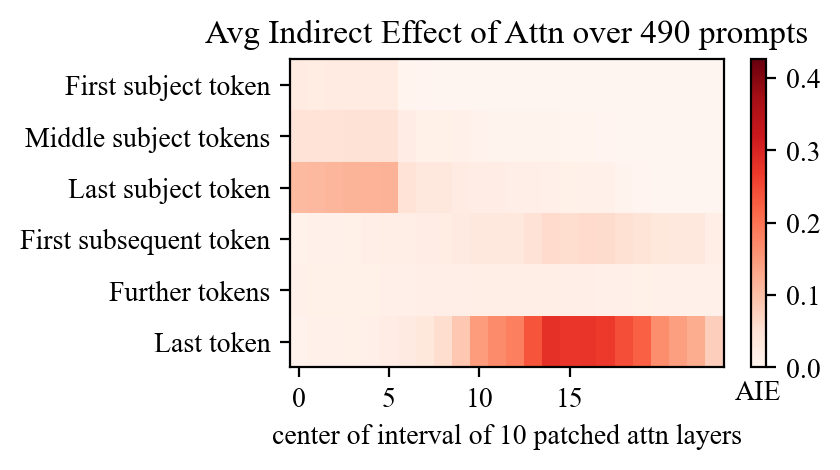

In [12]:
the_count = 1208
high_score = None  # Scale all plots according to the y axis of the first plot

for kind in [None, "mlp", "attn"]:
    d = read_knowlege(the_count, kind, arch)
    count = d["size"]
    what = {
        None: "Indirect Effect of $h_i^{(l)}$",
        "mlp": "Indirect Effect of MLP",
        "attn": "Indirect Effect of Attn",
    }[kind]
    title = f"Avg {what} over {count} prompts"
    result = numpy.clip(d["result"] - d["low_score"], 0, None)
    kindcode = "" if kind is None else f"_{kind}"
    if kind not in ["mlp", "attn"]:
        high_score = result.max()
    plot_array(
        result,
        kind=kind,
        title=title,
        low_score=0.0,
        high_score=high_score,
        archname=archname,
        savepdf=f"results/{arch}/causal_trace/summary_pdfs/rollup{kindcode}.pdf",
    )

In [16]:
numpy.clip(d["result"] - d["low_score"], 0, None)

array([[1.74659044e-02, 1.65818967e-02, 1.61356926e-02, 1.61750838e-02,
        1.62970386e-02, 1.58589073e-02, 1.87498704e-03, 9.33304429e-04,
        1.06737018e-04, 4.01139259e-04, 5.01815230e-04, 5.32984734e-04,
        6.20014966e-04, 4.90859151e-04, 6.16982579e-04, 5.80683351e-04,
        6.40455633e-04, 7.47308135e-04, 3.84084880e-04, 3.36695462e-04,
        1.75919384e-04, 1.93346292e-04, 1.31379813e-04, 1.58905983e-04],
       [5.20589612e-02, 5.27554713e-02, 5.33598326e-02, 5.35088666e-02,
        5.40707521e-02, 5.47585972e-02, 2.24387199e-02, 1.44634992e-02,
        1.50890835e-02, 1.18891075e-02, 9.83387604e-03, 9.11958888e-03,
        8.40512663e-03, 8.25955719e-03, 8.18556547e-03, 7.60061666e-03,
        6.18110597e-03, 5.57982177e-03, 1.76509097e-03, 9.80105251e-04,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [9.93318409e-02, 9.84635204e-02, 1.02944911e-01, 1.04623362e-01,
        1.06048107e-01, 1.08554393e-01, 4.24239300e-02, 2.7297

In [23]:
result = numpy.clip(d["result"] - d["low_score"], 0, None)
result.argmax(axis=1)

array([ 0,  5,  5, 14, 13, 14])

In [26]:
result[0,0], result[1,5], result[2,5], result[3,14], result[4,13], result[5,14]

(0.017465904, 0.054758597, 0.10855439, 0.04153988, 0.01952231, 0.27408904)

## Plot line graph

To make confidence intervals visible, we plot the data as line graphs below.

Reading None
Average Total Effect 0.4358763791877093
Best average indirect effect on last subject 0.14883905130208153
Best average indirect effect on last token 0.43587640899003166
Average best-fixed score 0.48823583
Average best-fixed on last subject token score 0.21832164
Average best-fixed on last word score 0.4821772
Argmax at last subject token 1
Max at last subject token 0.18635042
Argmax at last prompt token 23
Max at last prompt token 0.47338778
Reading mlp
Average Total Effect 0.4358763791877093
Best average indirect effect on last subject 0.14337570446313042
Best average indirect effect on last token 0.04727704304040092
Average best-fixed score 0.2999916
Average best-fixed on last subject token score 0.19526106
Average best-fixed on last word score 0.097170405
Argmax at last subject token 5
Max at last subject token 0.18088707
Argmax at last prompt token 15
Max at last prompt token 0.08478841
Reading attn
Average Total Effect 0.4358763791877093
Best average indirect effect on

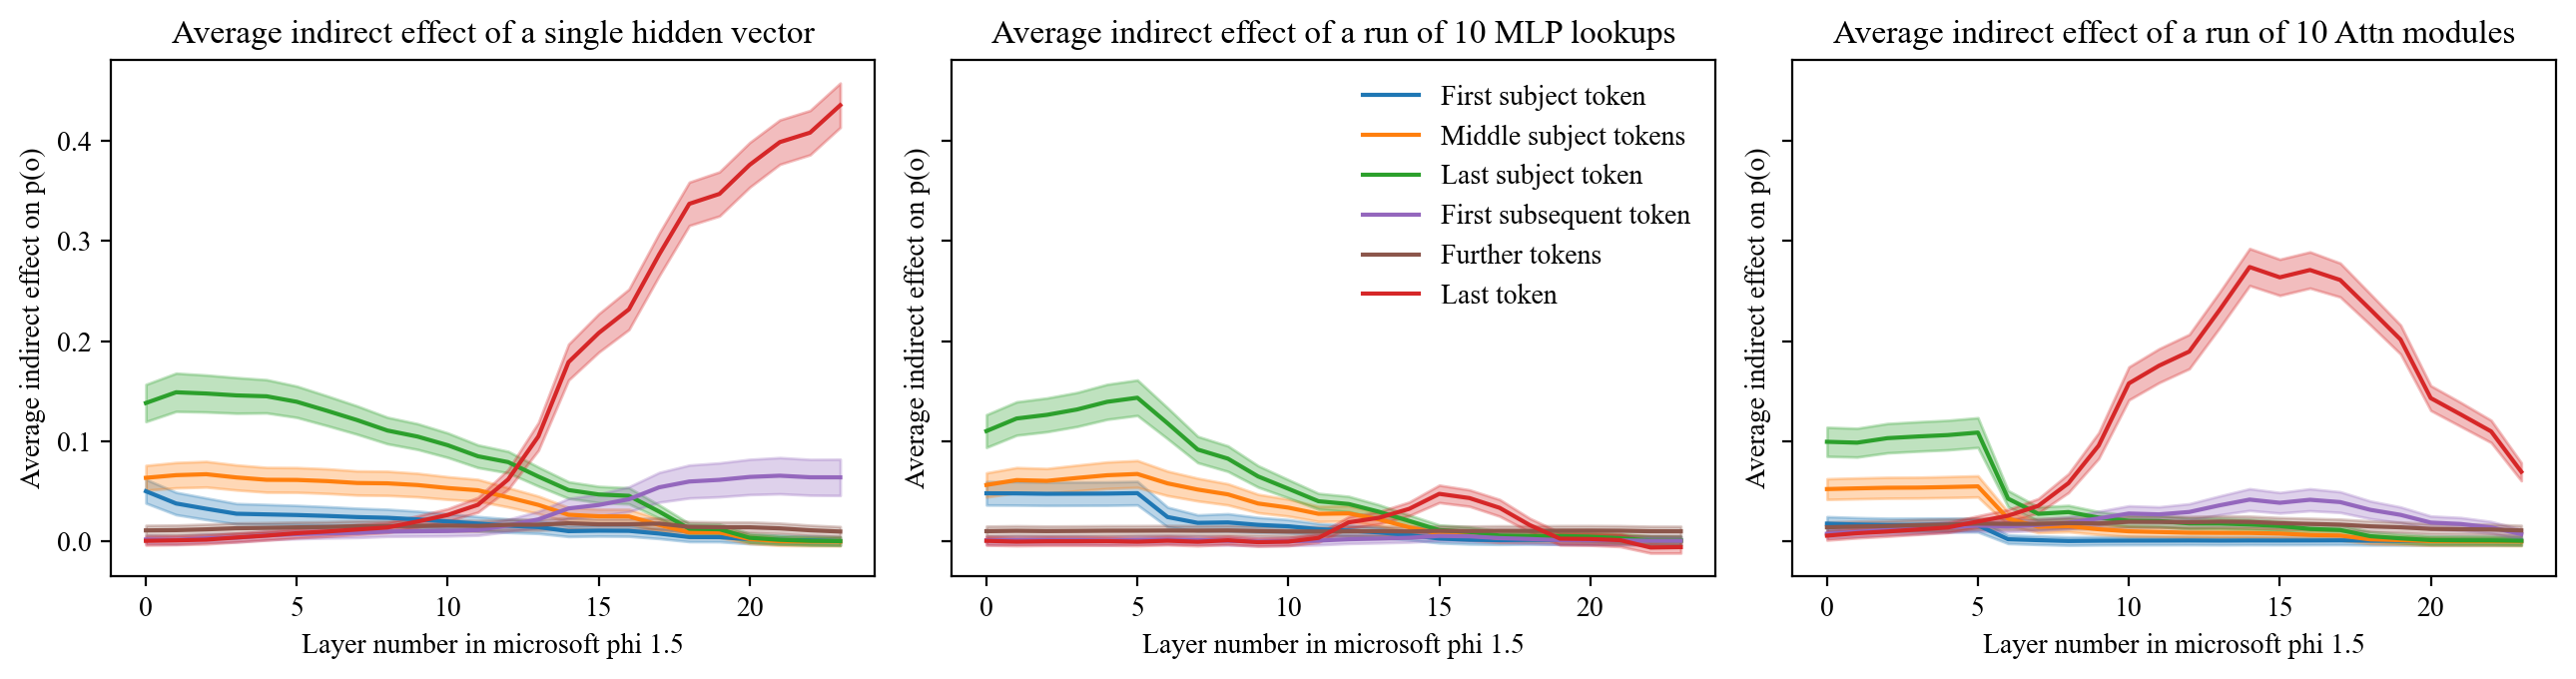

In [13]:
import math

labels = [
    "First subject token",
    "Middle subject tokens",
    "Last subject token",
    "First subsequent token",
    "Further tokens",
    "Last token",
]
color_order = [0, 1, 2, 4, 5, 3]
x = None

cmap = plt.get_cmap("tab10")
fig, axes = plt.subplots(1, 3, figsize=(13, 3.5), sharey=True, dpi=200)
for j, (kind, title) in enumerate(
    [
        (None, "single hidden vector"),
        ("mlp", "run of 10 MLP lookups"),
        ("attn", "run of 10 Attn modules"),
    ]
):
    print(f"Reading {kind}")
    d = read_knowlege(225, kind, arch)
    for i, label in list(enumerate(labels)):
        y = d["result"][i] - d["low_score"]
        if x is None:
            x = list(range(len(y)))
        std = d["result_std"][i]
        error = std * 1.96 / math.sqrt(count)
        axes[j].fill_between(
            x, y - error, y + error, alpha=0.3, color=cmap.colors[color_order[i]]
        )
        axes[j].plot(x, y, label=label, color=cmap.colors[color_order[i]])

    axes[j].set_title(f"Average indirect effect of a {title}")
    axes[j].set_ylabel("Average indirect effect on p(o)")
    axes[j].set_xlabel(f"Layer number in {archname}")
    # axes[j].set_ylim(0.1, 0.3)
axes[1].legend(frameon=False)
plt.tight_layout()
plt.savefig(f"results/{arch}/causal_trace/summary_pdfs/lineplot-causaltrace.pdf")
plt.show()